In [ ]:
# !unzip /content/test.zip
# !unzip /content/train.zip
!pip install torchinfo

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchinfo import summary



In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)


# torch.set_default_device(device)
device

# Load train data

In [ ]:
train_dir = "Data/train"

image_size = (224, 224)


train_transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize to target size
        transforms.ToTensor(),  # Convert image to tensor
    ]
)


train_data = ImageFolder(train_dir, transform=train_transform)
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

train_data

# Load Test data

In [ ]:
test_dir = "Data/test"
test_transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize to target size
        transforms.ToTensor(),  # Convert image to tensor
    ]
)

test_data = ImageFolder(test_dir, transform=test_transform)

test_data

In [ ]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Class names: {class_names}")

In [ ]:
fig = plt.figure(figsize=(10, 10))

row, col = 3, 3

for i in range(9):
    ax = fig.add_subplot(row, col, i + 1)
    random_idx = torch.randint(low=0, high=len(test_data), size=[1]).item()
    img, label = test_data[random_idx]

    ax.imshow(
        img.permute(1, 2, 0),
    )
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
train_count_dir = dict(Counter(train_data.targets))
train_count_dir = {class_names[key]: value for key, value in train_count_dir.items()}

test_count_dir = dict(Counter(test_data.targets))
test_count_dir = {class_names[key]: value for key, value in test_count_dir.items()}

colors = plt.cm.tab10(np.linspace(0, 1, len(train_count_dir)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Training dataset plot
ax1.bar(list(train_count_dir.keys()), list(train_count_dir.values()), color=colors)
ax1.set_xlabel("Labels")
ax1.set_ylabel("Counts")
ax1.set_title("Training Dataset Class Distribution")
ax1.tick_params(axis="x", rotation=45)

# Test dataset plot
ax2.bar(list(test_count_dir.keys()), list(test_count_dir.values()), color=colors)
ax2.set_xlabel("Labels")
ax2.set_ylabel("Counts")
ax2.set_title("Test Dataset Class Distribution")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64

generator = torch.Generator(device=device) if device.type == "mps" else None


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=generator)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, generator=generator)

In [ ]:
class Date_Custom_CNN(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=0,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 53 * 53, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):

        x = self.conv_block_1(x)

        x = self.conv_block_2(x)

        x = self.classifier(x)

        return x

In [ ]:
model = Date_Custom_CNN(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
# model(torch.randn(1, 3, 224, 224))
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
import torch

# import mlflow
from tqdm.auto import tqdm
from torch import nn


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_preds = model(X)

            loss = loss_fn(test_preds, y)
            test_loss += loss.item()

            test_pred_labels = test_preds.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def training(
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer,
    device: torch.device,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    checkpoint_path: str = 'best_model.pth',

):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    best_acc = 0.0



    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,)
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        print(
            f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), checkpoint_path)


    model.load_state_dict(torch.load(checkpoint_path))

    return results

In [14]:

EPOCHS = 100

LR = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

# Ensure the model is on the correct device
model.to(device)

results = training(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.2334 | Train acc: 0.1456 | Test loss: 2.1887 | Test acc: 0.1573
Epoch: 1 | Train loss: 2.1634 | Train acc: 0.1760 | Test loss: 2.1944 | Test acc: 0.1573
Epoch: 2 | Train loss: 2.1235 | Train acc: 0.1793 | Test loss: 2.0838 | Test acc: 0.2644
Epoch: 3 | Train loss: 1.9154 | Train acc: 0.3092 | Test loss: 1.6907 | Test acc: 0.3678
Epoch: 4 | Train loss: 1.5619 | Train acc: 0.4137 | Test loss: 1.8133 | Test acc: 0.3104
Epoch: 5 | Train loss: 1.4038 | Train acc: 0.5033 | Test loss: 1.2023 | Test acc: 0.5921
Epoch: 6 | Train loss: 1.1520 | Train acc: 0.5781 | Test loss: 1.2731 | Test acc: 0.5156
Epoch: 7 | Train loss: 0.9828 | Train acc: 0.6423 | Test loss: 0.9661 | Test acc: 0.6610
Epoch: 8 | Train loss: 0.8391 | Train acc: 0.7007 | Test loss: 0.9405 | Test acc: 0.6479
Epoch: 9 | Train loss: 0.6732 | Train acc: 0.7574 | Test loss: 0.9687 | Test acc: 0.6499
Epoch: 10 | Train loss: 0.5758 | Train acc: 0.7977 | Test loss: 0.7358 | Test acc: 0.7372
Epoch: 11 | Train lo

<ipython-input-13-84b16d727618>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


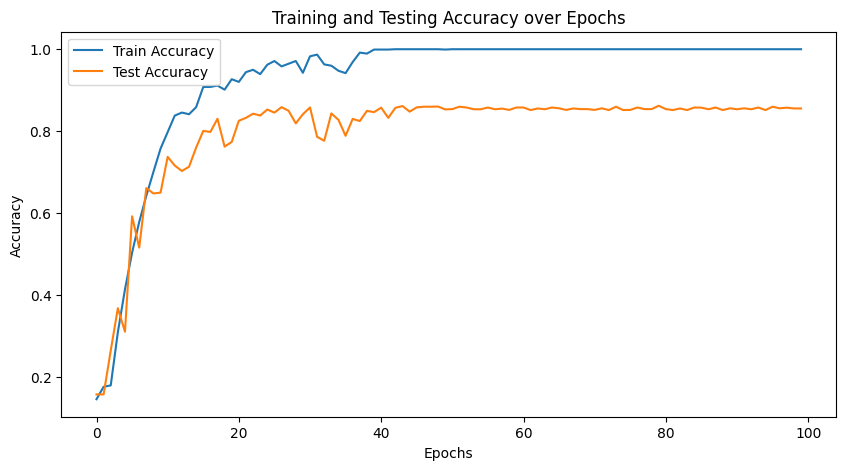

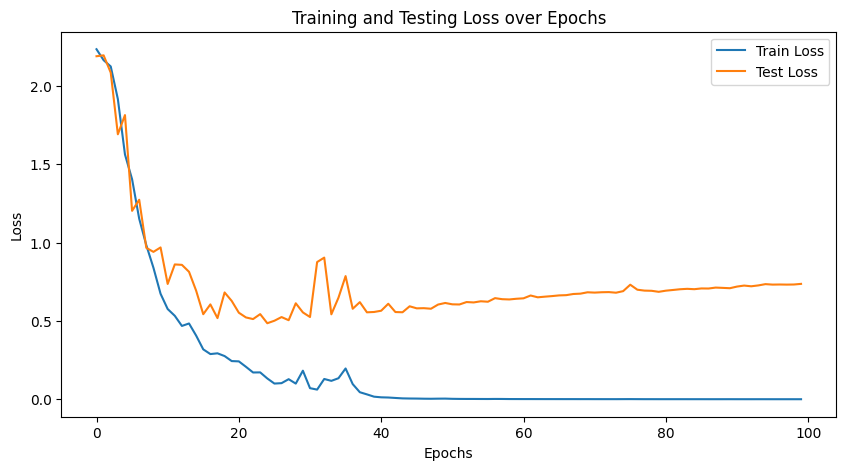

In [15]:

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(results["train_acc"], label='Train Accuracy')
plt.plot(results["test_acc"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], label='Train Loss')
plt.plot(results["test_loss"], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

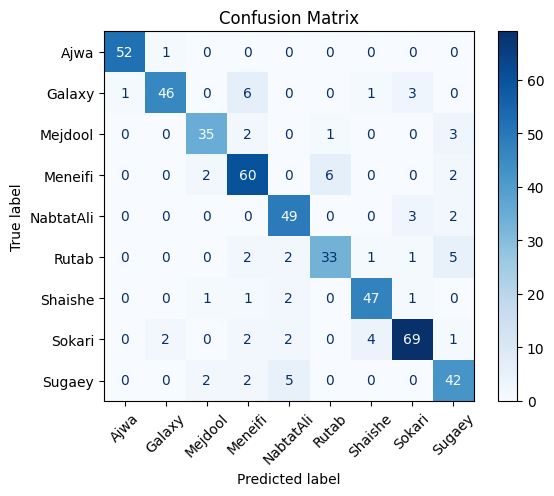

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names)) 


              precision    recall  f1-score   support

        Ajwa       0.98      0.98      0.98        53
      Galaxy       0.94      0.81      0.87        57
     Mejdool       0.88      0.85      0.86        41
     Meneifi       0.80      0.86      0.83        70
   NabtatAli       0.82      0.91      0.86        54
       Rutab       0.82      0.75      0.79        44
     Shaishe       0.89      0.90      0.90        52
      Sokari       0.90      0.86      0.88        80
      Sugaey       0.76      0.82      0.79        51

    accuracy                           0.86       502
   macro avg       0.86      0.86      0.86       502
weighted avg       0.87      0.86      0.86       502

